# Ex 1

In [189]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import pinv
from scipy.optimize import least_squares
import pylops
from pylops import MatrixMult, FirstDerivative
from pylops.optimization.sparsity import splitbregman      


Text(0.5, 1.0, 'test measurements (1 to 100)')

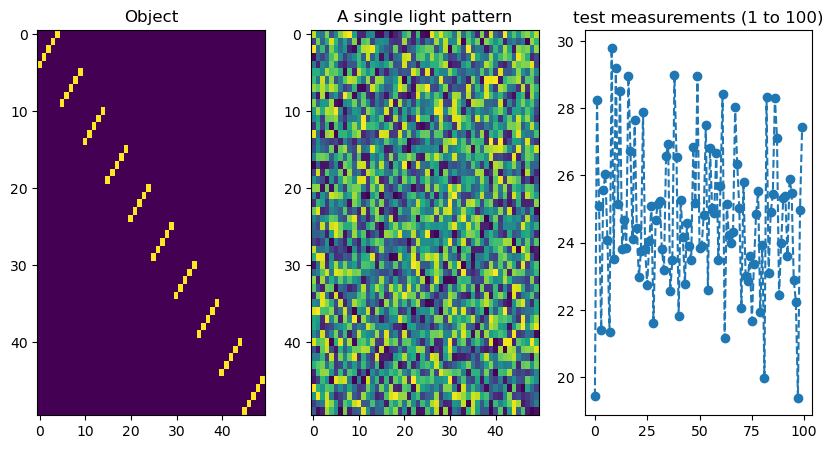

In [96]:
# 1. create the object
obj = np.identity(10); obj = np.kron(obj, np.fliplr(np.identity(5)))
# 2. create the refes
N = 5000 # number of realizations 
ref = np.random.random([obj.shape[0],obj.shape[1],N])
# 3. create the tests
test = (ref*obj[:,:,np.newaxis]).sum(axis=(0,1))
# 4. reconstruct the object

fig, ax = plt.subplots(1,3,figsize = [10,5])
ax[0].imshow(obj, aspect='auto'); ax[0].set_title('Object')
ax[1].imshow(ref[:,:,0], aspect='auto'); ax[1].set_title('A single light pattern')
ax[2].plot(test[:100], '--o',); ax[2].set_title('test measurements (1 to 100)')


Text(0.5, 1.0, 'rec')

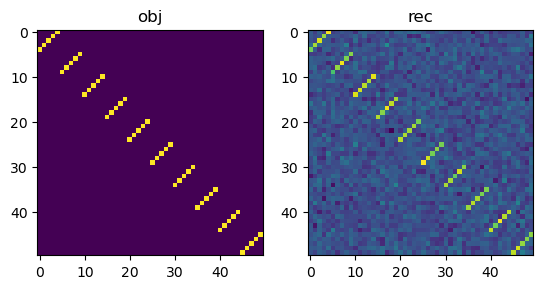

In [3]:
# GI reconstruction
rec = np.mean(ref*test,axis=2) - np.mean(ref,axis=2)*np.mean(test)
plt.figure()
plt.subplot(121); plt.imshow(obj); plt.title('obj')
plt.subplot(122); plt.imshow(rec); plt.title('rec')

## GI with larger features in ref

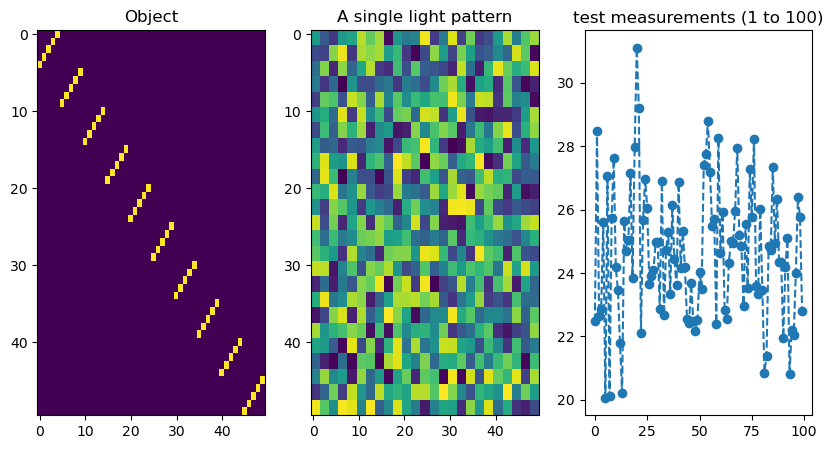

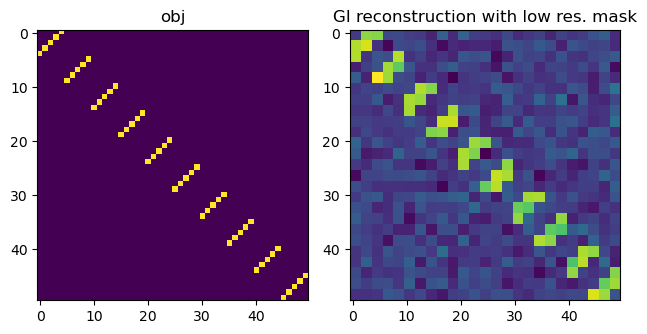

In [ ]:
N = 5000 # number of realizations 
scaling_fac = 2
nx, ny = obj.shape
low_res_ref = np.random.random([int(nx/scaling_fac),int(ny/scaling_fac),N])
ref = np.kron(low_res_ref,np.ones([scaling_fac,scaling_fac,1]))

test = (ref*obj[:,:,np.newaxis]).sum(axis=(0,1))

fig, ax = plt.subplots(1,3,figsize = [10,5])
ax[0].imshow(obj, aspect='auto'); ax[0].set_title('Object')
ax[1].imshow(ref[:,:,0], aspect='auto'); ax[1].set_title('A single light pattern')
ax[2].plot(test[:100], '--o',); ax[2].set_title('test measurements (1 to 100)')
plt.show()

rec = np.mean(ref*test,axis=2) - np.mean(ref,axis=2)*np.mean(test)
plt.figure()
plt.subplot(121); plt.imshow(obj); plt.title('obj')
plt.subplot(122); plt.imshow(rec); plt.title('rec')
plt.title('GI reconstruction with low res. mask')
plt.tight_layout()

## SNR vs. N

In [ ]:
from IPython.display import display, clear_output
import time

N = 10000 # number of realizations 
ref = np.random.random([obj.shape[0],obj.shape[1],N])
test = (ref*obj[:,:,np.newaxis]).sum(axis=(0,1))

def SNR(img):
    return img.mean()/img.std()

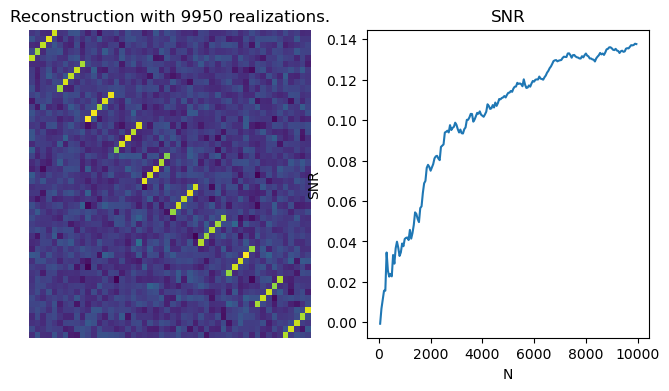

In [31]:
# GI with larger features in ref
snr = []
num_of_realizations = []
for N in np.arange(0,10000,50): # number of realizations 
    rec = np.mean(ref[:,:,:N]*test[:N],axis=2) - np.mean(ref[:,:,:N],axis=2)*np.mean(test[:N])
    snr.append(SNR(rec)); num_of_realizations.append(N)

    fig, ax = plt.subplots(1,2,figsize=(8, 4))
    ax[0].imshow(rec,aspect='auto')
    ax[0].set_title(f'''Reconstruction with {N} realizations.''')
    ax[0].axis('off')  

    ax[1].plot(num_of_realizations,snr)
    ax[1].set_xlabel('N'); ax[1].set_ylabel('SNR')
    ax[1].set_title('SNR')

    display(fig)
    clear_output(wait=True)
    plt.close(fig)
    # time.sleep(0.5)


# Ex 2

## 1. adding noise

Text(0.5, 1.0, 'rec with noise')

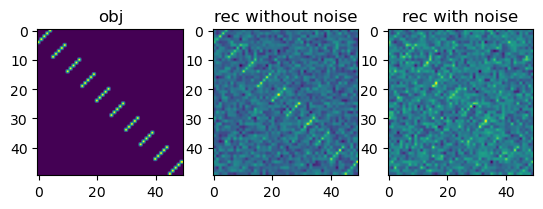

In [65]:
N = 1000 # number of realizations 
ref = np.random.random([obj.shape[0],obj.shape[1],N])
noiseless_test = (ref*obj[:,:,np.newaxis]).sum(axis=(0,1))

nx, ny, _ = ref.shape
beam_intensity = 20

mu, sig = [50,50]

beam_noise = np.random.poisson(beam_intensity, size=(nx, ny, N))
detector_noise = np.random.normal(mu,sig,size=N)

test = (beam_noise*ref*obj[:,:,np.newaxis]).sum(axis=(0,1)) + detector_noise
# GI reconstruction
rec = np.mean(ref*test,axis=2) - np.mean(ref,axis=2)*np.mean(test)
clear_rec = np.mean(ref*noiseless_test,axis=2) - np.mean(ref,axis=2)*np.mean(noiseless_test)
plt.figure()
plt.subplot(131); plt.imshow(obj); plt.title('obj')
plt.subplot(132); plt.imshow(clear_rec); plt.title('rec without noise')
plt.subplot(133); plt.imshow(rec); plt.title('rec with noise')


## 4. Pseudo Inverse, Least squares and TV

In [164]:
obj = np.identity(10); obj = np.kron(obj, np.fliplr(np.identity(5)))
N = 1000 # number of realizations 
ref = np.random.random([obj.shape[0],obj.shape[1],N])

nx, ny, _ = ref.shape
beam_intensity = 10000
mu, sig = [50,50]

beam_noise = np.random.poisson(beam_intensity, size=(nx, ny, N))
detector_noise = np.random.normal(mu,sig,size=N)

noiseless_test = (ref*obj[:,:,np.newaxis]).sum(axis=(0,1))
test = (beam_noise*ref*obj[:,:,np.newaxis]).sum(axis=(0,1)) + detector_noise


In [ ]:
############################################# GI #############################################
GI_rec = np.mean(ref*test,axis=2) - np.mean(ref,axis=2)*np.mean(test)

############################################# Pseudo inverse #############################################
reshaped_ref = np.reshape(ref,[nx*ny, N]).T
# reshaped_ref -= reshaped_ref.mean(1)
# test_centered = test - test.mean()

inv_ref   = np.linalg.pinv(reshaped_ref)
rec    = inv_ref @ test
pinv_rec = rec.reshape(nx, ny)

############################################# Least squares #############################################
A = ref.reshape(Ny * Nx, N).T        
A -= A.mean(axis=1, keepdims=True)   
test = test - test.mean()

def residual(x):
    return A @ x - test              

x0 = np.zeros(A.shape[1])            # initial guess (all zeros)
result = least_squares(residual, x0)   # or "trf", "dogbox"
x = result.x                     # length-2500 solution

ls_rec = x_hat.reshape(Ny, Nx)

############################################# TV #############################################

reshaped_ref -= reshaped_ref.mean(1, keepdims=True)
test_centered = test - test.mean()

Op_ref = MatrixMult(reshaped_ref)                              # PyLops linear operator

Dx = FirstDerivative(dims=(ny, nx), axis=0, edge=False)
Dy = FirstDerivative(dims=(ny, nx), axis=1, edge=False)
D2x = pylops.SecondDerivative(dims=(ny, nx), axis=0, edge=False)
D2y = pylops.SecondDerivative(dims=(ny, nx), axis=1, edge=False)
Reg = [Dx, Dy, D2x, D2y]

mu  = 1.0     # data-fidelity weight
lam = [100, 100, 50, 50]    # L1 regularisation weight  (tune empirically)

out = splitbregman(Op_ref, 
                            test_centered,
                            Reg,          # sparsity operator
                            niter_outer=100,
                            niter_inner=10,
                            mu=mu,
                            epsRL1s=lam,
                            tol=1e-4,
                            tau=1,
                            show=True,
                            **dict(iter_lim=5, damp=1e-4)
                            )

TV_rec = out[0].reshape([ny, nx])


Text(0.5, 1.0, 'TV, SNR=0.0')

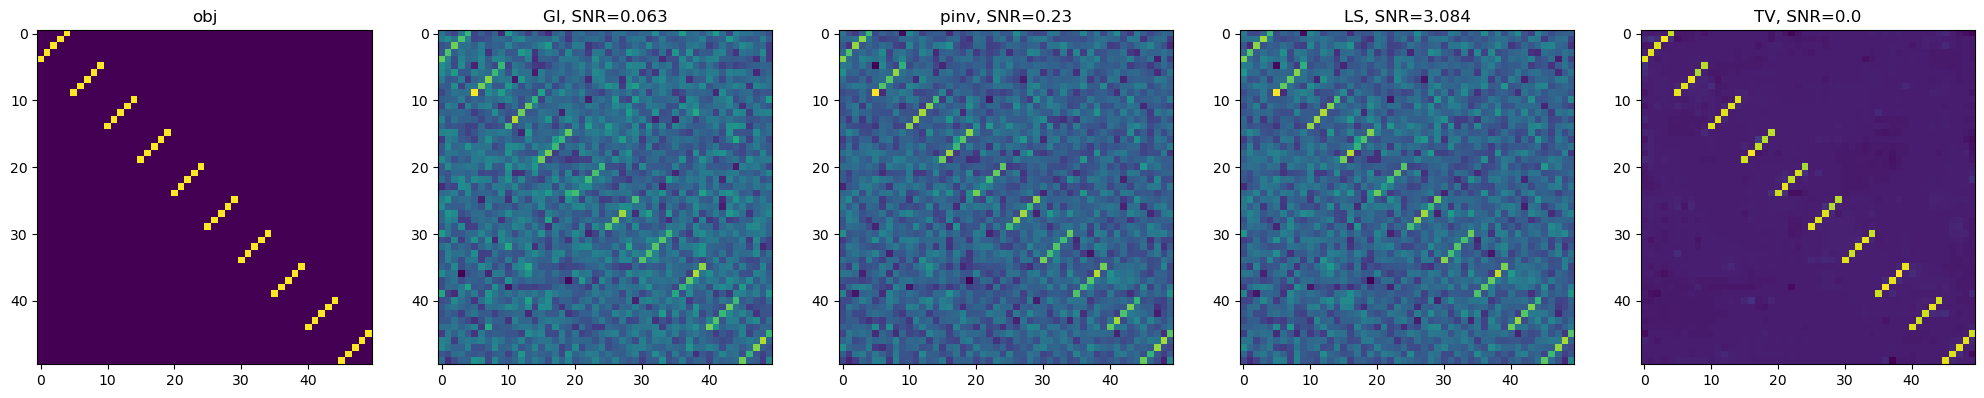

In [230]:
fig, ax = plt.subplots(1,5, figsize=[25,5])
ax[0].imshow(obj); ax[0].set_title(f'obj')
ax[1].imshow(GI_rec); ax[1].set_title(f'GI, SNR={round(SNR(GI_rec),3)}')
ax[2].imshow(pinv_rec); ax[2].set_title(f'pinv, SNR={round(SNR(pinv_rec),3)}')
ax[3].imshow(ls_rec); ax[3].set_title(f'LS, SNR={round(SNR(ls_rec),3)}')
ax[4].imshow(TV_rec); ax[4].set_title(f'TV, SNR={round(SNR(TV_rec),3)}')